# import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,BatchNormalization,MaxPooling2D,Conv2D,Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import Model
from sklearn.metrics import classification_report , confusion_matrix

# get images from dataset files

In [2]:
train_normal = glob.glob('/kaggle/input/spine-fracture-prediction-from-xrays/cervical fracture/train/normal/*.png')
train_fracture = glob.glob('/kaggle/input/spine-fracture-prediction-from-xrays/cervical fracture/train/fracture/*.png')

val_normal = glob.glob('/kaggle/input/spine-fracture-prediction-from-xrays/cervical fracture/val/normal/*.png')
val_fracture = glob.glob('/kaggle/input/spine-fracture-prediction-from-xrays/cervical fracture/val/fracture/*.png')

random.shuffle(train_normal)
random.shuffle(train_fracture)

print ('number of train normal x-rays = {}'.format(len (train_normal)))
print ('number of train pneumonia x-rays = {}'.format(len (train_fracture)))

print ('------------------------------------')

print ('number of test normal x-rays = {}'.format(len (val_normal)))
print ('number of test pneumonia x-rays = {}'.format(len (val_fracture)))

number of train normal x-rays = 1900
number of train pneumonia x-rays = 1900
------------------------------------
number of test normal x-rays = 200
number of test pneumonia x-rays = 200


# plot sample of each catogery

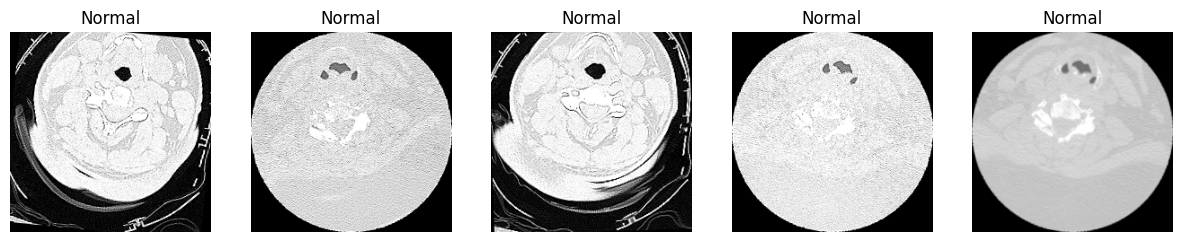

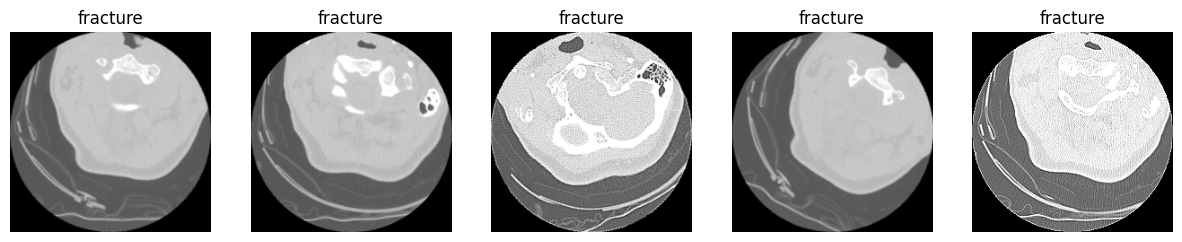

In [3]:
def plot_images (data ,image_title,num_of_images ,type_image = 'bgr'):
    plt.figure(figsize=(15,10))
    for i in range (num_of_images):
        random_image = random.choice(data)
        if type (data) == list:
            random_image = cv2.imread(random_image)
            
        if type_image.lower() == 'bgr':
            random_image =  cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
            
        plt.subplot(1,num_of_images,i+1)
        plt.imshow(random_image)
        plt.axis('off')
        plt.title (image_title)
    
    plt.show()

plot_images (train_normal ,'Normal',5)
plot_images (train_fracture ,'fracture',5)

# plot categories distribution

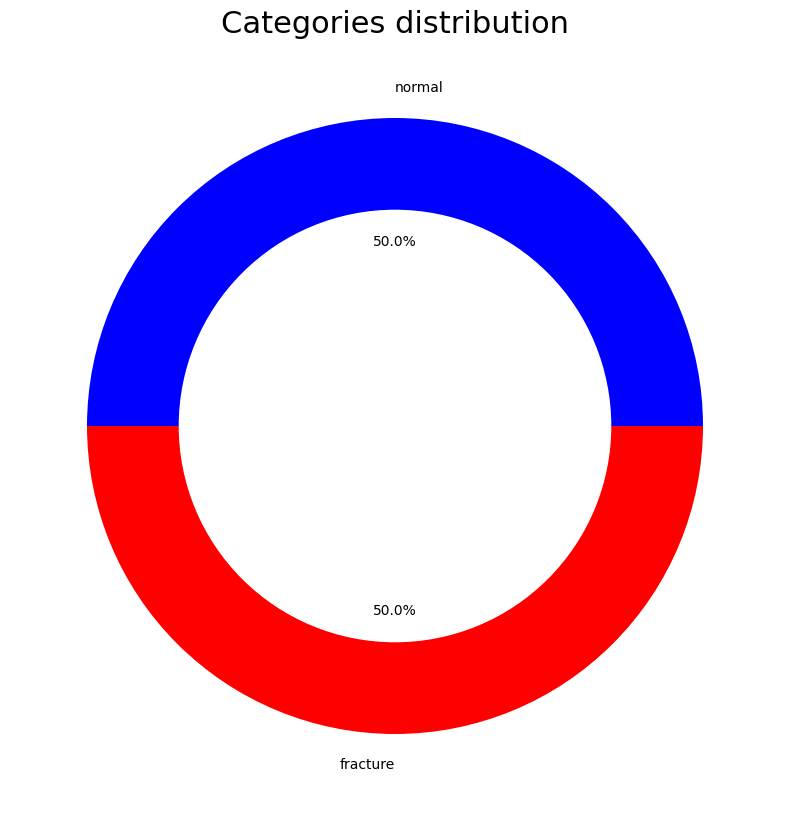

In [4]:
def plt_pie (data,labels,colors,title):
    plt.figure(figsize=(20,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(data,labels = labels, colors = colors , autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title (title,fontsize = 22)
    plt.show()
    
data = [len (train_normal) , len (train_fracture) ]
labels = ['normal' , 'fracture' ]
colors = ['blue','red']
plt_pie (data,labels,colors , 'Categories distribution')

# define function to agumante image

In [5]:
def image_augmentation(data,target , p=0.5):
    
    images =[]
    
    albumentation_list = [A.RandomBrightness(limit = 0.5, p=p),A.RGBShift(p=p), A.RandomContrast(limit = 0.5,p =p) ,
                          A.Rotate(p=p, limit=40) , A.RandomCrop(p=p,height = 200, width = 200)]
    
    while (len (images) < target):
        for image in data:
            img = cv2.resize(cv2.imread(image), (256, 256) )
            operation = random.choice(albumentation_list)
            img = operation (image = img)['image']
            
            if img.shape[0] !=256:
                img = cv2.resize (img , (256, 256))
    
            images.append (img)
        
            if (len (images) >= target):
                break
    return np.array (images)

# define function to get images and resize it from links 

In [6]:
def convert_links_to_images(data):
    images =[]
    for image in data:
        img = cv2.resize(cv2.imread(image), (256, 256) )
        images.append(img)
    return np.array (images)

# get train and test images

In [7]:
train_normal_images = image_augmentation(train_normal,3500,p=0.7)
train_fracture_images = image_augmentation(train_fracture,3500,p=0.7)

val_normal_images = convert_links_to_images(val_normal)
val_fracture_images = convert_links_to_images(val_fracture)

# plot sample from each category after preprocessing

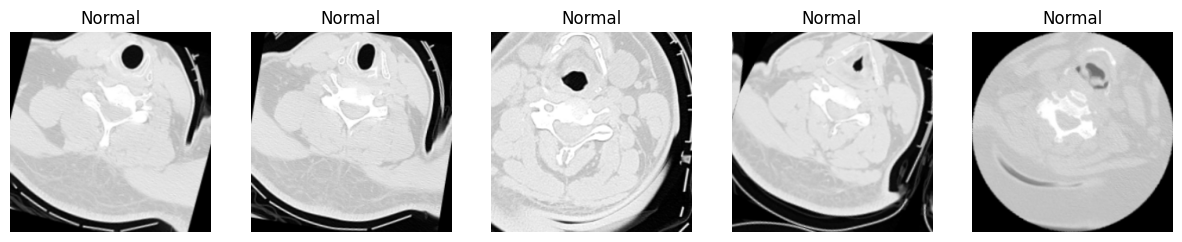

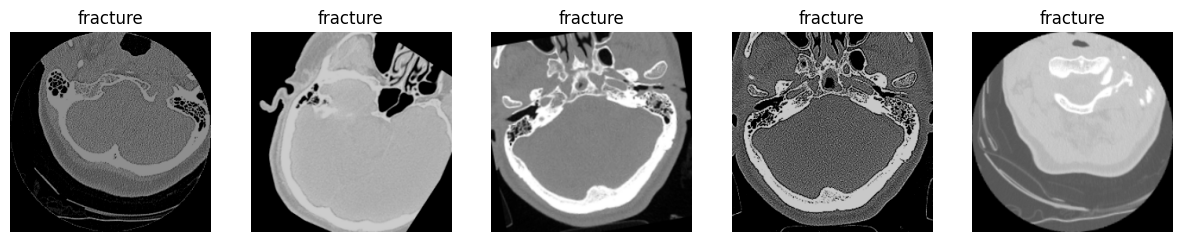

In [8]:
#Train data
plot_images (train_normal_images ,'Normal',5)
plot_images (train_fracture_images ,'fracture',5)

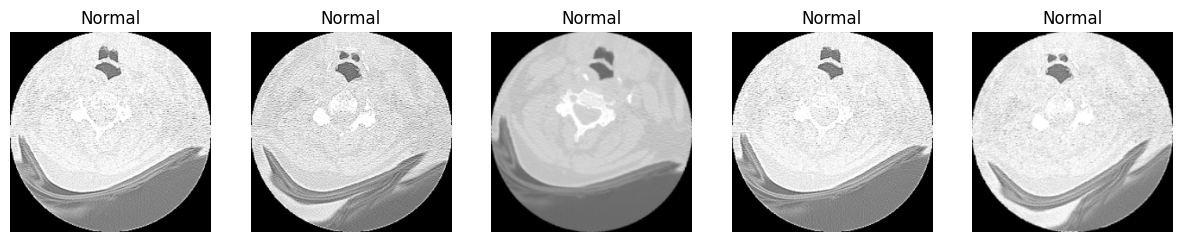

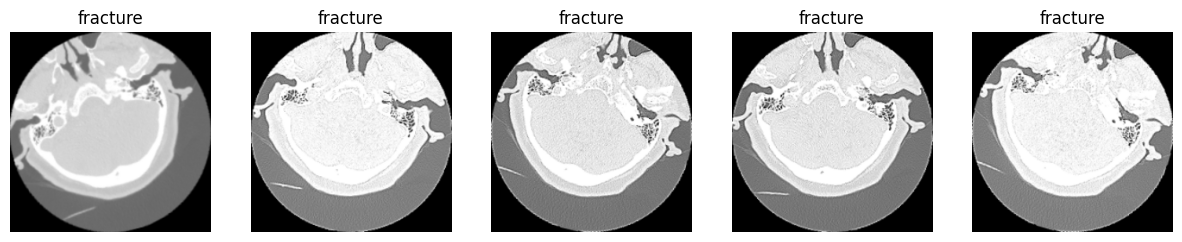

In [9]:
#Test data
plot_images (val_normal_images ,'Normal',5)
plot_images (val_fracture_images ,'fracture',5)

# get train and test data

In [10]:
y_train = np.concatenate ([np.zeros (len(train_normal_images)) , np.ones (len (train_fracture_images)) ])
X_train = np.concatenate ([train_normal_images,train_fracture_images],axis = 0)

y_test = np.concatenate ([np.zeros (len(val_normal_images)) , np.ones (len (val_fracture_images))] )
X_test = np.concatenate ([val_normal_images,val_fracture_images],axis = 0)

print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)
#--------------------------------free some memory--------------------------------
train_normal_images,train_pneumonia_images,test_normal_images,test_pneumonia_images = None,None,None,None
del train_normal_images,train_pneumonia_images,test_normal_images,test_pneumonia_images 

(7000, 256, 256, 3)
(7000,)
(400, 256, 256, 3)
(400,)


# create datagenerator for train and test images

In [11]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255,)

train_generator = train_datagen.flow(X_train, y_train,batch_size=16,shuffle=True)
test_generator = test_datagen.flow(X_test, y_test,batch_size=16,shuffle=False)
#--------------------------------free some memory--------------------------------
X_train,y_train,X_test = None, None,None
del X_train,y_train,X_test

# get inception_v3 pre trained model

In [12]:
inception = keras.applications.inception_v3.InceptionV3 (input_shape = (256,256,3),
                                                            include_top = False,
                                                            weights = 'imagenet')
inception.trainable = False   

87910968/87910968 [==============================] - 0s 0us/step


# build full-model and fit model

In [18]:
last_output = inception.get_layer('mixed8').output 
x = Flatten()(last_output)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inception.input, outputs=x)
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights = True,verbose = 1),
             ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]
            
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,epochs=50,validation_data=test_generator,callbacks=[callbacks])
model.load_weights('model.h5')

Epoch 1/50
438/438 [==============================] - 100s 218ms/step - loss: 0.0947 - accuracy: 0.9676 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 2/50
438/438 [==============================] - 94s 214ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 3/50
438/438 [==============================] - 96s 219ms/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 5.3750e-04 - val_accuracy: 1.0000
Epoch 4/50
438/438 [==============================] - 95s 216ms/step - loss: 0.0127 - accuracy: 0.9954 - val_loss: 3.1582e-04 - val_accuracy: 1.0000
Epoch 5/50
438/438 [==============================] - 95s 217ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 1.7435e-04 - val_accuracy: 1.0000
Epoch 6/50
438/438 [==============================] - 93s 213ms/step - loss: 0.0157 - accuracy: 0.9933 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 7/50
438/438 [==============================] - 95s 216ms/step - loss: 0.0175 - accuracy: 0.9937 - val_loss: 1.

# plot loss and accuracy

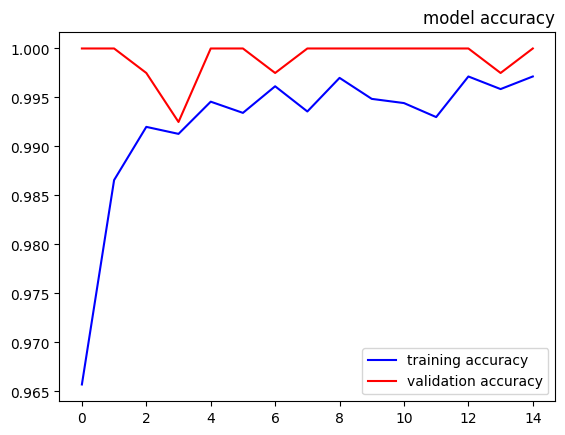

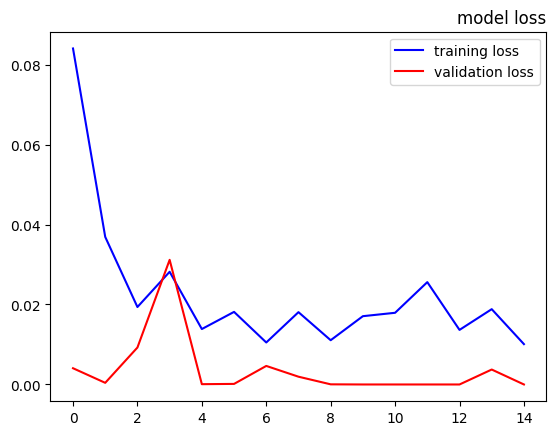

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss'] 
tarin_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range (len (tarin_acc)),tarin_acc,c='b',label = 'training accuracy')
plt.plot (range (len (val_acc)),val_acc,c='r',label = 'validation accuracy')
plt.title ('model accuracy',loc ='right')
plt.legend()
plt.show()

plt.plot(range (len (train_loss)),train_loss,c='b',label = 'training loss')
plt.plot (range (len (val_loss)),val_loss,c='r',label = 'validation loss')
plt.title ('model loss',loc ='right')
plt.legend()
plt.show()

# get predicted output

In [16]:
y_pred = model.predict (test_generator)
y_pred = y_pred.reshape (-1,)
y_pred = np.float16(y_pred>=0.5 )

25/25 [==============================] - 2s 40ms/step


# print confusion matrix and classification report

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       200
         1.0       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



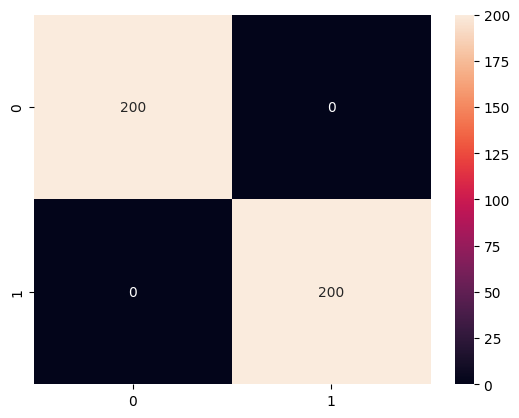

In [17]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,fmt='d')
print (classification_report (y_test,y_pred))